In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
import torch
import attention
import audio_utils as audio

from datasets import load_from_disk

In [3]:
dataset = load_from_disk("/home/jovyan/tedlium/validation.hf").with_format("torch").select(range(100))

In [4]:
model, processor = attention.init()

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
print(dataset[10])

{'audio': tensor([ 0.0033,  0.0018,  0.0003,  ...,  0.0005, -0.0027, -0.0020]), 'text': 'if they get surrounded they notice that too they might get a little flustered and they can also sense their motion and tilt'}


In [6]:
example = dataset[10]["audio"]

"""
Promising examples: 2, 3, 4, 10

Not promising examples: 1
""";

In [12]:
snippets = torch.load("snippets.pt").detach()

/tmp/ipykernel_8949/3837330112.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snippets = torch.load("snippets.pt").detach()


In [13]:
encoder_limit = int((example.size(0) + snippets.size(1)) / 16000 * 50) + 1
encoder_limit

498

In [14]:
snippets.shape

torch.Size([20, 10240])

In [15]:
example.device, snippets.device

(device(type='cpu'), device(type='cuda', index=0))

In [16]:
c_attns_tgt = []
for s in snippets.to(example.device):
    _, _, _, _, c_attns = attention.inference(torch.cat([s, example]), model, processor, skip_special_tokens=True)
    c_attns_stacked_cutoff = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)[:, :, :, :encoder_limit][0, 2]
    c_attns_tgt.append(c_attns_stacked_cutoff)

/home/jovyan/libs/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
WhisperModel is using WhisperSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [17]:
max_seq_len = max([c.size(0) for c in c_attns_tgt])

In [18]:
c_attns_tgt_padded = [torch.nn.functional.pad(c, (0, 0, 0, max_seq_len - c.size(0)), value=0.0) for c in c_attns_tgt]

In [20]:
c_attns_tgt_stacked = torch.stack(c_attns_tgt_padded)

100% 20/20 [00:28<00:00,  1.43s/it]


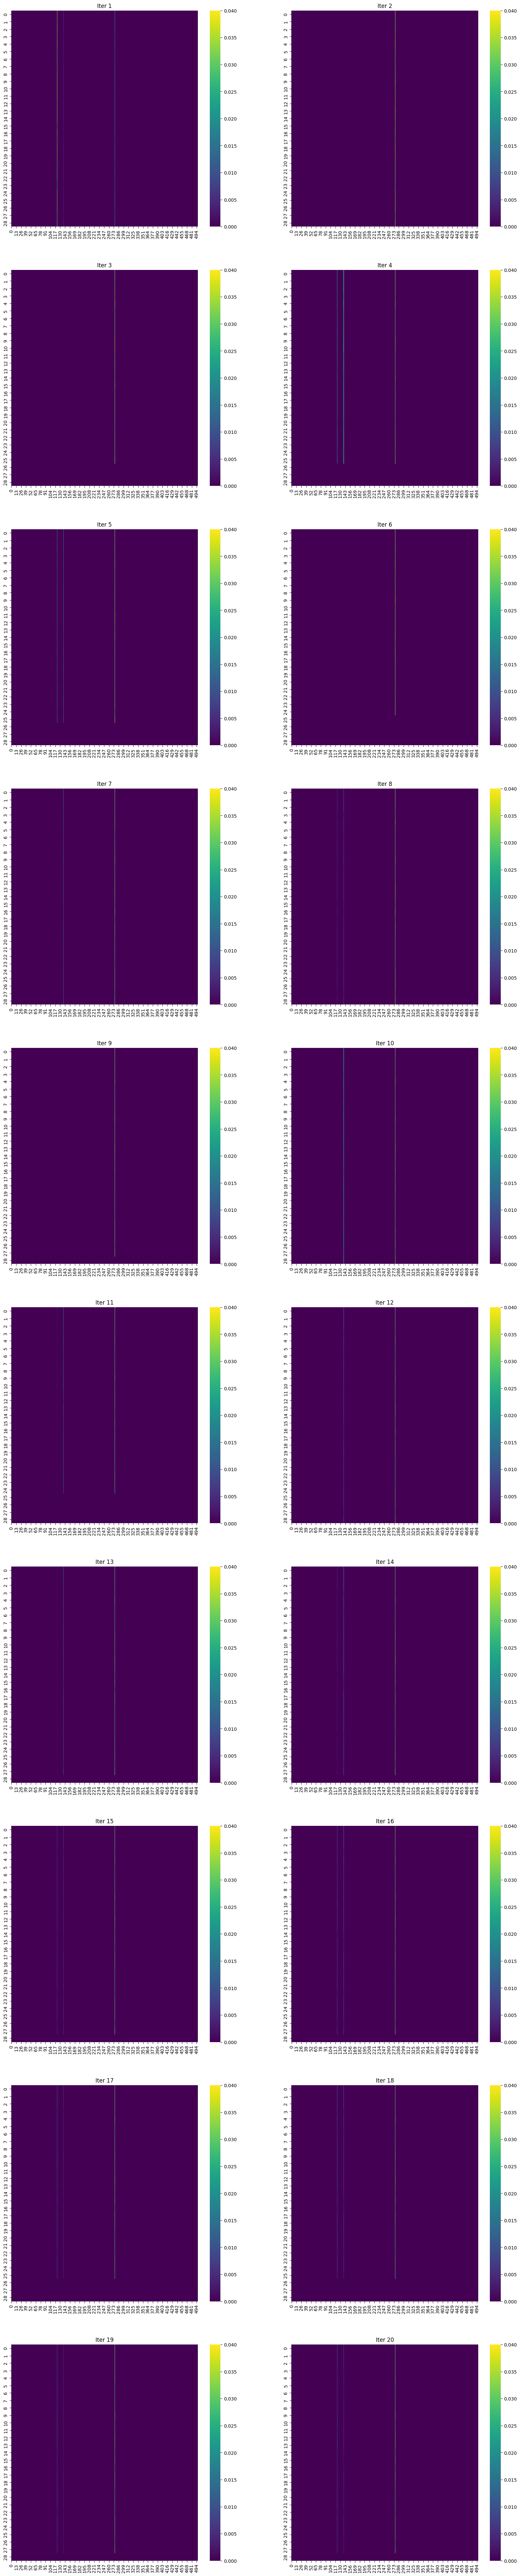

In [22]:
attention.plot_attns_over_iters(c_attns_tgt_stacked, 10, 2, vmax=0.04)

In [93]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import seaborn as sns
def plot_attns_iters_anim(attns,
                          vmin: float = 0.0, vmax: float = 1.0,
                          figsize = (10, 10), cmap: str = "viridis",
                          filename = None) -> None:
    """
    Plot the attention maps in a grid
    """
    attns_list = [a.cpu().squeeze(0) for a in attns]
    fig, ax = plt.subplots(figsize=figsize)
    hm = sns.heatmap(attns_list[0], ax=ax, cmap="viridis", vmin=vmin, vmax=vmax)
    
    def update(frame):
        hm = sns.heatmap(attns_list[frame], ax=ax, cmap="viridis", vmin=vmin, vmax=vmax)
        ax.set_title(f"Iter {frame + 1}")
        return hm
        
    anim = animation.FuncAnimation(fig=fig, func=update, frames=20, interval=200, repeat=False)
    return anim

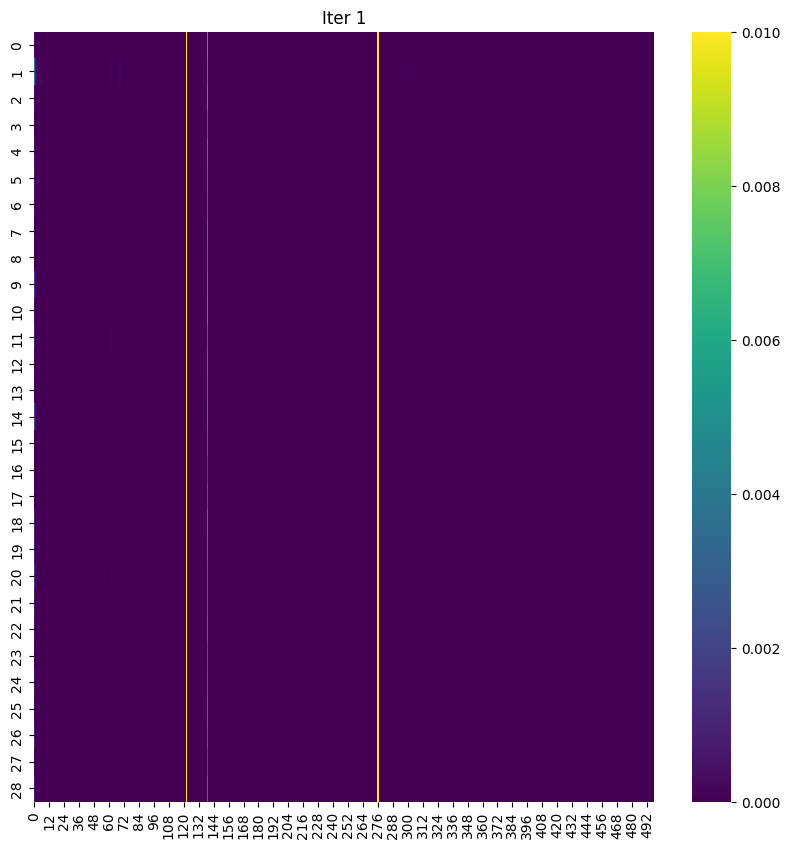

In [94]:
anim = plot_attns_iters_anim(c_attns_tgt_stacked, vmax=0.01)

In [95]:
anim.save("movie.mp4")

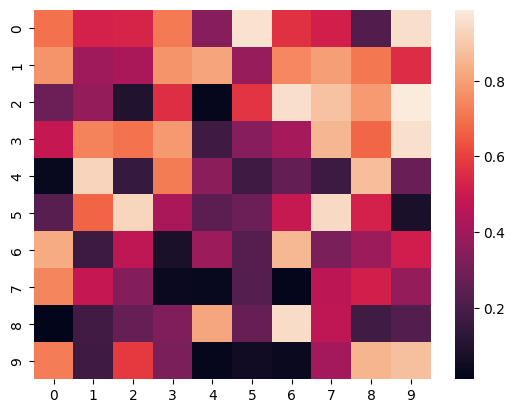

In [97]:
ax = sns.heatmap(torch.rand((10, 10)))

In [98]:
ax.set_data(torch.rand(10, 10))

AttributeError: 'Axes' object has no attribute 'set_data'